In [1]:
import os                              
import numpy as np
from numpy import number                    
import pandas as pd                     
import matplotlib.pyplot as plt  
import math
from typing import List
from azure.quantum.optimization import Problem, ProblemType, Term
from azure.quantum.optimization import ParallelTempering
from azure.quantum.optimization import Term, SlcTerm

<h3 style="color:yellow;"> Data Preprocessing </h3>

In [2]:
stocks = [stock.split('.')[0] for stock in sorted(os.listdir("Datasets/Bombay Stock Exchange Top 50 (last 20 years data)"))]
stocks = stocks[1:]

print(stocks)

['ADANIENT', 'ADANIGREEN', 'ADANIPORTS', 'ADANIPOWER', 'ADANITRANS', 'ASIANPAINT', 'ATGL', 'AXISBANK', 'BAJAJ-AUTO*', 'BAJAJFINSV', 'BAJFINANCE', 'BHARTIARTL', 'BRITANNIA', 'COALINDIA', 'DABUR', 'DIVISLAB', 'DMART', 'HCLTECH', 'HDFC', 'HDFCBANK', 'HDFCLIFE', 'HINDUNILVR', 'HINDZINC', 'ICICIBANK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'PIDILITIND', 'POWERGRID', 'RELIANCE', 'SBILIFE', 'SBIN', 'SIEMENS', 'SUNPHARMA', 'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO', 'WIPRO']


In [3]:
dates = pd.date_range('2020-06-27', '2022-06-27') 
data = pd.DataFrame({'Time': dates})


In [4]:
for stock in stocks:
    prices = pd.read_csv("Datasets/Bombay Stock Exchange Top 50 (last 20 years data)/"+stock+".csv", usecols=['Date', 'WAP'])
    #print(prices)
    prices['Date'] = pd.to_datetime(prices['Date'], dayfirst = True)  
    #print(prices)
    prices.rename(                                                            
        columns={"Date": "Time", "WAP": stock},
        inplace=True
    )
    data = pd.merge(data,prices)


In [5]:
cp = data .drop(['Time'], axis=1).tail(1).to_numpy()
cp = cp[0]

In [6]:
r = data[(data['Time'] >= '2020-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
r.head()

,ADANIENT,ADANIGREEN,ADANIPORTS,ADANIPOWER,ADANITRANS,ASIANPAINT,ATGL,AXISBANK,BAJAJ-AUTO*,BAJAJFINSV,...,SBIN,SIEMENS,SUNPHARMA,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,WIPRO
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.003303,-0.049927,0.014850,-0.004988,-0.037398,0.005966,-0.015178,0.006920,0.005066,0.011924,...,0.000865,0.007351,-0.017048,0.000601,0.047004,-0.003164,-0.000443,0.010112,0.021308,-0.007733
2,-0.010636,-0.049903,-0.006293,-0.009519,0.007948,-0.006665,-0.002781,0.035394,-0.002453,0.016905,...,0.014059,-0.015242,-0.008919,0.004799,-0.025907,0.001420,-0.005275,-0.004628,0.004782,-0.002084
3,0.007015,-0.000395,0.007715,0.002276,0.010551,-0.002579,0.047833,0.009497,0.007152,0.033348,...,0.018608,0.004666,0.005206,0.016795,0.021360,0.020015,0.022206,0.021991,0.004248,0.021089
4,0.017205,0.102695,0.041561,-0.001960,-0.013318,0.011123,-0.009999,-0.001076,0.021797,-0.001638,...,-0.006828,0.035929,0.009218,0.029517,0.005488,0.021521,0.022392,0.023023,0.000064,0.006637


In [7]:
mu = r.mean().to_numpy()
sigma = r.cov().to_numpy()
n=len(stocks)

In [8]:
'''
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "e87e6b08-4913-4522-9206-ba18a56ee0fa",
    resource_group = "AzureQuantum",
    name = "MTCProjectQuantumSharique",
    location = "East US"
)


from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "6e02aef9-2670-4418-92b8-7659cf5605d2",
    resource_group = "azurequantum",
    name = "workspace1",
    location = "japaneast"
)
'''

from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "ad18d2e0-288d-409a-bc11-5231714f4fb8",
    resource_group = "rg-mtc-poc-quantum",
    name = "ws-mtc-poc-quantum",
    location = "japaneast"
)



In [9]:
 
def Return(mu,n):
    """Calculates the Terms for the return component of the cost function

    Parameters
    ----------
    mu : np.array
        Expected return of each stock 
    n : integer
        Number of stocks
        
    Returns
    -------
    terms: list
        List of Terms associated with the return component of the cost function
    """
    
    terms=[]
    
    for i in range(0,n):
        
        terms.append(Term(c=-1*mu[i] , indices=[i]))
    print("Number of terms in return: ", len(terms))
    return terms

<h3 style="color:yellow;">Optimized Portfolio </h3>

In [10]:
import fun

t1= Return(mu,n)
t2= fun.risk(sigma, n, 1)
terms=[]
terms=t1+t2
problem = Problem(name="Portfolio optimization", problem_type=ProblemType.pubo, terms=terms)
solver = ParallelTempering(workspace)
solution = solver.optimize(problem)


Number of terms in return:  49
Number of terms in risk:  2401
......{'0': 1, '1': 1, '2': 0, '3': 1, '4': 1, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 1, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 1, '25': 0, '26': 0, '27': 1, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 1, '40': 1, '41': 1, '42': 1, '43': 0, '44': 0, '45': 0, '46': 1, '47': 0, '48': 0}


In [11]:
print(solution['configuration'])
result = solution['configuration']
#print(type(result))

selected_stocks=[]
prices_selected=[]
index_prices_selected= []

daily_prices = data.drop(['Time'], axis=1).to_numpy()
#print(daily_prices)

for i in result.keys():
    if result[i]:
        selected_stocks.append(stocks[int(i)])
        prices_selected.append(cp[int(i)])
        index_prices_selected.append(int(i))
        
print("\nSelected stocks are -\n", index_prices_selected)

print("\nPrice of selected stocks are -\n", prices_selected)

{'0': 1, '1': 1, '2': 0, '3': 1, '4': 1, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 1, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 1, '25': 0, '26': 0, '27': 1, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 1, '40': 1, '41': 1, '42': 1, '43': 0, '44': 0, '45': 0, '46': 1, '47': 0, '48': 0}

Selected stocks are -
 [0, 1, 3, 4, 6, 17, 24, 27, 39, 40, 41, 42, 46]

Price of selected stocks are -
 [2188.648926689398, 1906.6661531149095, 273.4378450035677, 2149.2141705744434, 2295.5344228094573, 997.2557371818474, 1476.0546642603206, 581.4109040683994, 461.347105474746, 2374.566375643609, 842.2730643765593, 415.93760931737654, 2046.4069499762488]


In [12]:
# Printing results
import fun
print("OPTIMIZSED PORTFOLIO :\n")
no_of_shares = fun.distributed_budget(1000000, arr= selected_stocks, cp=cp, index_prices_selected= index_prices_selected)
edroi = fun.find_expected_daily_return(mu,selected_stocks,index_prices_selected)
print("\nConstraints:")
print("\nBudget : ",  u"\u20B9", 1000000)
print("Risk Aversion index of :" , 1,"\n")
print("Expected Annual Return on Investment : ", round((edroi*252 *100),3), "%")
print("Expected Annual Return: ",  u"\u20B9", round((1000000 + edroi*252*1000000),1))
print("Annual Risk percentage: ", round(fun.find_risk(selected_stocks,n,result,sigma)*(252**0.5),4) ,"%")

OPTIMIZSED PORTFOLIO :

ADANIENT  :  35  shares
ADANIGREEN  :  40  shares
ADANIPOWER  :  281  shares
ADANITRANS  :  35  shares
ATGL  :  33  shares
HCLTECH  :  77  shares
INFY  :  52  shares
JSWSTEEL  :  132  shares
SBIN  :  166  shares
SIEMENS  :  32  shares
SUNPHARMA  :  91  shares
TATAMOTORS  :  184  shares
TITAN  :  37  shares

Constraints:

Budget :  ₹ 1000000
Risk Aversion index of : 1 

Expected Annual Return on Investment :  77.261 %
Expected Annual Return:  ₹ 1772609.5
Annual Risk percentage:  22.0944 %


<h3 style="color:yellow;"> Diversified Portfolio </h3>

In [13]:
terms=[]
t1 = Return(mu,n)
t2 = fun.risk(sigma,n,1)
t3 = fun.budget_constraint(2*n,n,15)
terms= t1+ t2 + t3
problem = Problem(name="Portfolio optimization", problem_type=ProblemType.pubo, terms=terms)
solver = ParallelTempering(workspace)
solution = solver.optimize(problem)

Number of terms in return:  49
Number of terms in risk:  2401
........

In [14]:
print(solution['configuration'])
result = solution['configuration']

selected_stocks=[]
prices_selected=[]
index_prices_selected= []

daily_prices = data.drop(['Time'], axis=1).to_numpy()


for i in result.keys():
    if result[i]:
        selected_stocks.append(stocks[int(i)])
        prices_selected.append(cp[int(i)])
        index_prices_selected.append(int(i))
        
print("\nSelected stocks are -\n", selected_stocks)

print("\nPrice of selected stocks are -\n", prices_selected)

{'0': 1, '1': 1, '2': 0, '3': 1, '4': 1, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 1, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 1, '24': 1, '25': 0, '26': 0, '27': 1, '28': 0, '29': 0, '30': 1, '31': 0, '32': 0, '33': 0, '34': 0, '35': 1, '36': 0, '37': 0, '38': 1, '39': 0, '40': 0, '41': 1, '42': 0, '43': 0, '44': 1, '45': 0, '46': 1, '47': 0, '48': 0}

Selected stocks are -
 ['ADANIENT', 'ADANIGREEN', 'ADANIPOWER', 'ADANITRANS', 'ATGL', 'DIVISLAB', 'ICICIBANK', 'INFY', 'JSWSTEEL', 'M&M', 'PIDILITIND', 'SBILIFE', 'SUNPHARMA', 'TCS', 'TITAN']

Price of selected stocks are -
 [2188.648926689398, 1906.6661531149095, 273.4378450035677, 2149.2141705744434, 2295.5344228094573, 3681.668983122961, 720.4213247084797, 1476.0546642603206, 581.4109040683994, 1082.335401291108, 2152.832107682206, 1087.0919934192486, 842.2730643765593, 3332.5401743514335, 2046.4069499762488]


In [15]:
# Printing results

print("\n DIVERSIFIED PORTFOLIO:")
no_of_shares = fun.distributed_budget(1000000, selected_stocks, cp, index_prices_selected)
edroi = fun.find_expected_daily_return(mu,selected_stocks,index_prices_selected)
print("\nConstraints:")
print("\nBudget : ",  u"\u20B9", 1000000)
print("Stock Appetite: ", 15 , " stocks")
print("Risk Aversion index of :" , 1,"\n")
print("Expected Annual Return on Investment : ", round((edroi*252 *100),3), "%")
print("Expected Annual Return: ",  u"\u20B9", round((1000000 + edroi*252*1000000),1))
print("Annual Risk percentage: ", round(fun.find_risk(selected_stocks,n,result,sigma)*(252**0.5),4) ,"%")



 DIVERSIFIED PORTFOLIO:
ADANIENT  :  30  shares
ADANIGREEN  :  34  shares
ADANIPOWER  :  243  shares
ADANITRANS  :  31  shares
ATGL  :  29  shares
DIVISLAB  :  18  shares
ICICIBANK  :  92  shares
INFY  :  45  shares
JSWSTEEL  :  114  shares
M&M  :  61  shares
PIDILITIND  :  30  shares
SBILIFE  :  61  shares
SUNPHARMA  :  79  shares
TCS  :  20  shares
TITAN  :  32  shares

Constraints:

Budget :  ₹ 1000000
Stock Appetite:  15  stocks
Risk Aversion index of : 1 

Expected Annual Return on Investment :  65.083 %
Expected Annual Return:  ₹ 1650827.3
Annual Risk percentage:  19.3219 %


End


<h3 style="color:yellow;"> Visualization </h3>

In [16]:
portfolio = pd.DataFrame(data['Time'])
for i in range(len(selected_stocks)):
       portfolio = portfolio.join(data[data.columns[1+index_prices_selected[i]]])
       
pr = portfolio[(portfolio['Time'] >= '2020-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
pr.head()

pmu = pr.mean().to_numpy()
psigma = pr.cov().to_numpy()

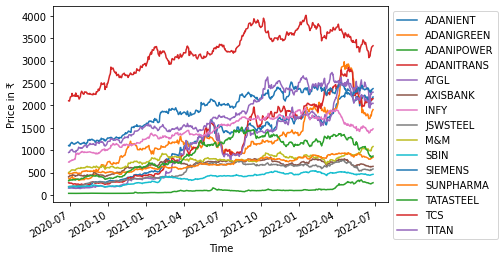

In [29]:
portfolio.plot(x ='Time', y = portfolio.columns[1:], kind = 'line')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Price in \u20B9')
plt.show()

In [30]:
def find_expected_daily_return_sp(weights,portfolio_mu,n):
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''
    expected_daily_roi=0
    for i in range(0,n):
        t = weights[i] * portfolio_mu[i]
        expected_daily_roi+=t
    return expected_daily_roi

In [31]:
from statistics import variance


def find_risk_sp(weights,portfolio_var,n):

    '''Calculates the risk for the optimised portfolio
    
    Parameters
    ----------
    B: float
        budget to be equally invested
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    risk_perc: float
        percetnage risk value of the optimised portfolio with given budget
    '''
    
    var=0
    for i in range(0,n):
        for j in range(0,n):
            t = weights[i]  * weights[j] * portfolio_var[i][j]
            var+=t
    risk = var**0.5
    risk_perc = risk * 100
    return risk_perc

In [32]:
def randomly_weighted_portfolios_with_selected_stocks(nof_portfolio, portfolio_return, portfolio_sigma):
    all_w_list = []
    all_b_list = []
    weight = np.random.random(len(selected_stocks))
    weight /= np.sum(weight)
    all_w_list.append(weight)
    random_portfolios = np.zeros((2,nof_portfolio))
    for i in range(nof_portfolio):
        weight = np.random.random(len(selected_stocks))
        weight /= np.sum(weight)
        all_w_list.append(weight)
        random_portfolios[0,i] = find_expected_daily_return_sp(weight, portfolio_return,len(selected_stocks))*30*100
        random_portfolios[1,i] = find_risk_sp(weight, portfolio_sigma,len(selected_stocks))
    return random_portfolios

In [33]:
def visualize_efficient_frontier_for_selected_stocks():
    simulated_portfolios = randomly_weighted_portfolios_with_selected_stocks(25000,pmu,psigma)
    plt.figure(figsize=(10, 7))
    plt.scatter(simulated_portfolios[1,:],simulated_portfolios[0,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.ylabel('Expected Monthly retrun on investment')
    plt.xlabel('Risk Percentage')
    plt.show()

In [34]:
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns


all_prices=  data.drop(['Time'], axis=1)
sample_cov = risk_models.sample_cov(all_prices, frequency=252)
muc = expected_returns.mean_historical_return(all_prices)


w_classical = [0.0161,0.24485, 0.10312 , 0.23497, 0.01057, 0.20492, 0.13906, 0.04642]
w_classical_all = [0,0.0161,0,0.24485,0.10312,0,0.23497,0,0,0,0,0.01057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.20492,0,0,0,0.13906,0,0,0,0,0,0,0,0,0,0,0.04642,0,0,0,0,0,0,0]
return_based_on_classical_w = find_expected_daily_return_sp(w_classical, muc, 8)*22

risk_based_on_classical_w  = find_risk_sp(w_classical_all, (sample_cov.reset_index(drop = True)).to_numpy(), 49)
print(return_based_on_classical_w,risk_based_on_classical_w)


28.691789345712255 29.73474442716532


In [35]:
quantum_risk = find_risk()
quantum_return = edroi * 22 *100
print(quantum_risk,quantum_return)

1.3044456707744985 6.070902731919574


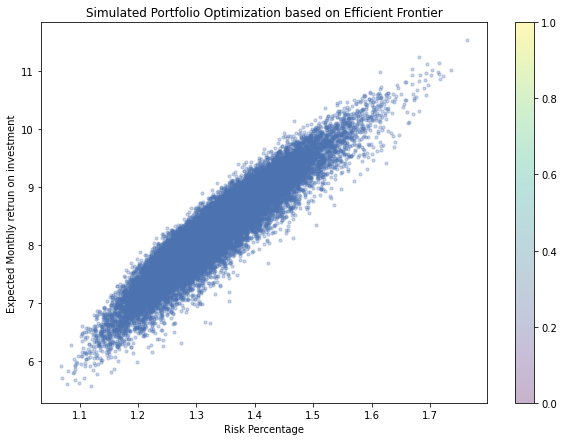

In [36]:
visualize_efficient_frontier_for_selected_stocks()